In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import keras
import tensorflow as tf

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

In [3]:
def load_dataset_from_csv(dir):
    X = []
    y = []
    ids = []

    for root, dirs, files in os.walk(dir):
        dirs.sort()
        files = sorted(files)
        for file in files:
            if file.endswith('.csv') and not file.startswith('empty'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                if df['time'].iloc[0] != 0.002:
                    print(f"{file_path} has a time value of {df['time'].iloc[0]}, expected 0.002")
                features = df[['fsr1','fsr2','cs1','cs2']].values
                label = df['obj'].iloc[0]
                X.append(features)
                y.append(label)
                ids.append(file[:-4])

    X = np.array(X)
    y = np.array(y)
    ids = np.array(ids)

    return X, y, ids

In [4]:
X, y, ids = load_dataset_from_csv('./dataset/')

./dataset/ball/ball_22.csv has a time value of 29.702, expected 0.002
./dataset/bigball/bigball_01.csv has a time value of 4.802, expected 0.002
./dataset/bigball/bigball_05.csv has a time value of 20.302, expected 0.002
./dataset/box/box_08.csv has a time value of 4.852, expected 0.002
./dataset/box/box_23.csv has a time value of 16.752, expected 0.002
./dataset/box/box_36.csv has a time value of 19.602, expected 0.002
./dataset/cube/cube_06.csv has a time value of 22.352, expected 0.002
./dataset/cube/cube_07.csv has a time value of 6.452, expected 0.002
./dataset/cube/cube_10.csv has a time value of 39.202, expected 0.002
./dataset/cube/cube_46.csv has a time value of 18.552, expected 0.002
./dataset/jenga/jenga_32.csv has a time value of 4.752, expected 0.002
./dataset/labello/labello_22.csv has a time value of 5.852, expected 0.002
./dataset/metalbrick/metalbrick_14.csv has a time value of 9.352, expected 0.002
./dataset/smallbutton/smallbutton_23.csv has a time value of 20.552, e

In [5]:
print("Number of samples:", X.shape[0])
print("Number of timesteps per sample:", X.shape[1])
print("Number of features per timestep:", X.shape[2])
print("Number of classes:", len(np.unique(y)))
print("Number of samples per class:")
class_counts = pd.Series(y).value_counts()
class_counts

Number of samples: 774
Number of timesteps per sample: 150
Number of features per timestep: 4
Number of classes: 16
Number of samples per class:


button            55
smallbutton       55
ball              48
bigball           48
box               48
case              48
cube              48
cylinder          48
jenga             48
labello           48
lemon             48
metalbrick        48
smallcube         48
syringe           48
tomato            48
parallelepiped    40
Name: count, dtype: int64

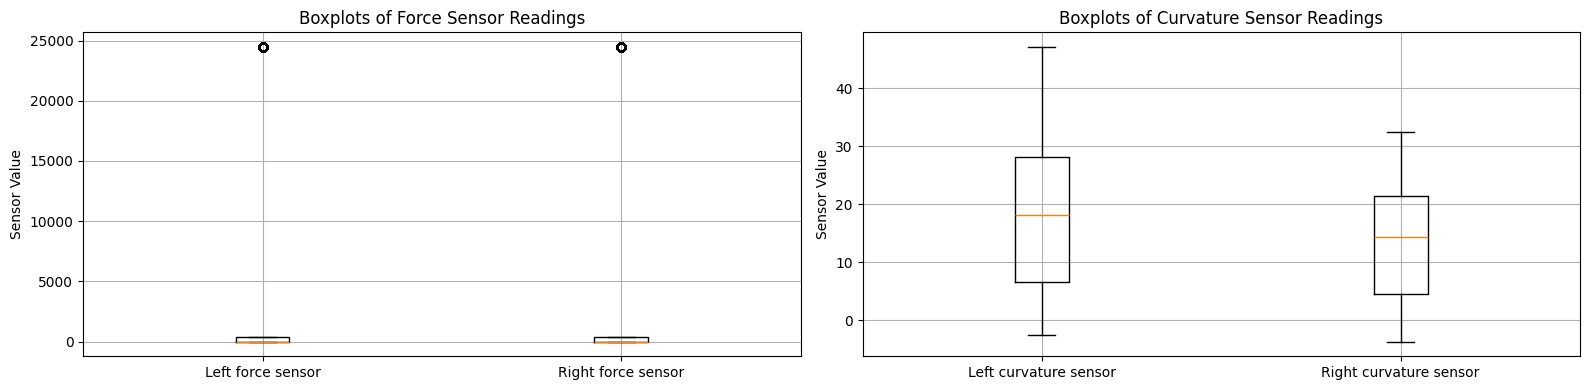

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].boxplot([X[:, :, 0].flatten(),  X[:, :, 1].flatten()], tick_labels=['Left force sensor', 'Right force sensor'])
axs[0].set_title('Boxplots of Force Sensor Readings')
axs[0].set_ylabel('Sensor Value')
axs[0].grid(True)

axs[1].boxplot([X[:, :, 2].flatten(),  X[:, :, 3].flatten()], tick_labels=['Left curvature sensor', 'Right curvature sensor'])
axs[1].set_title('Boxplots of Curvature Sensor Readings')
axs[1].set_ylabel('Sensor Value')
axs[1].grid(True)

plt.tight_layout()

In [7]:
def plot_random_samples(X, y, obj_ids, feature, num_objs_to_plot):
    if feature == 'fsr1':
        feature_idx = 0
        feature_name = 'Left force sensor'
    elif feature == 'fsr2':
        feature_idx = 1
        feature_name = 'Right force sensor'
    elif feature == 'cs1':
        feature_idx = 2
        feature_name = 'Left curvature sensor'
    elif feature == 'cs2':
        feature_idx = 3
        feature_name = 'Right curvature sensor'
    else:
        raise ValueError("Invalid feature specified. Choose from 'fsr1', 'fsr2', 'cs1', 'cs2'.")
    _, axs = plt.subplots(len(np.unique(y)), 1, figsize=(20, 3*len(np.unique(y))), sharey=True)
    colors = sns.color_palette("hls", num_objs_to_plot)
    for i, obj in enumerate(np.unique(y)):
        objs = np.where(y == obj)[0]
        objs_sub = np.random.choice(objs, size=num_objs_to_plot, replace=False)
        for j, obj_idx in enumerate(objs_sub):
            axs[i].plot(X[obj_idx, :, feature_idx], '-o', color=colors[j], markersize=4)
        axs[i].set_title(f'{feature_name} - {obj_ids[objs_sub[0]]}')
        axs[i].grid()
        axs[i].set_ylabel('Sensor Value')
        axs[i].set_xlabel('Time Steps')
    plt.tight_layout()

In [8]:
# plot_random_samples(X, y, ids, feature='fsr1', num_objs_to_plot=3)

In [9]:
# plot_random_samples(X, y, ids, feature='fsr2', num_objs_to_plot=3)

In [10]:
# plot_random_samples(X, y, ids, feature='cs1', num_objs_to_plot=3)

In [11]:
# plot_random_samples(X, y, ids, feature='cs2', num_objs_to_plot=3)

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)
y_mapping = {index: str(label) for index, label in enumerate(le.classes_)}
X_train, X_dev, y_train, y_dev, ids_train, ids_dev = train_test_split(
    X, y, ids, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_dev, y_dev, ids_dev, test_size=0.5, random_state=RANDOM_SEED, stratify=y_dev
)

In [13]:
np.savez_compressed(
    'dataset.npz',
    X_train=X_train, y_train=y_train, ids_train=ids_train,
    X_val=X_val, y_val=y_val, ids_val=ids_val,
    X_test=X_test, y_test=y_test, ids_test=ids_test,
    y_mapping=y_mapping
)

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(X_train.shape)
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(X_val.shape)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(X_test.shape)

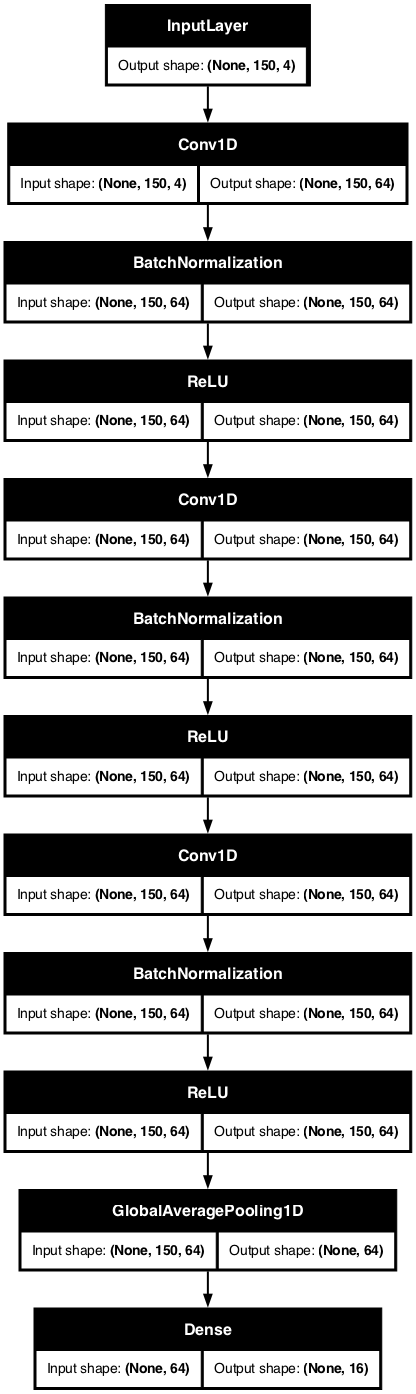

In [15]:
def make_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# TODO: aggiungi dropout, riduci il numero di filtri, i layer
# e.g. conv1 = keras.layers.Dropout(0.3)(conv1), after ReLU

model = make_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train)))
keras.utils.plot_model(model, show_shapes=True, dpi=72)

In [16]:
epochs = 1000
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"], # labels are integers, not one-hot encoded
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7762 - sparse_categorical_accuracy: 0.0901 - val_loss: 2.6843 - val_sparse_categorical_accuracy: 0.1129 - learning_rate: 0.0010
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4819 - sparse_categorical_accuracy: 0.2712 - val_loss: 2.5697 - val_sparse_categorical_accuracy: 0.1532 - learning_rate: 0.0010
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3539 - sparse_categorical_accuracy: 0.3191 - val_loss: 2.4786 - val_sparse_categorical_accuracy: 0.1613 - learning_rate: 0.0010
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2487 - sparse_categorical_accuracy: 0.3307 - val_loss: 2.4070 - val_sparse_categorical_accuracy: 0.1935 - learning_rate: 0.0010
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1715 - sparse_categorical_accuracy: 0.3381 - val_loss: 2.3141 - val_sparse_categorical_accuracy: 0.1855 - learning_rate: 0.0010
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

In [17]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Keras prints the running average during the evaluation loop, while evaluate() returns the final values after aggregating all batches

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9624 - sparse_categorical_accuracy: 0.7390  
Test accuracy 0.7435897588729858
Test loss 0.9524239897727966


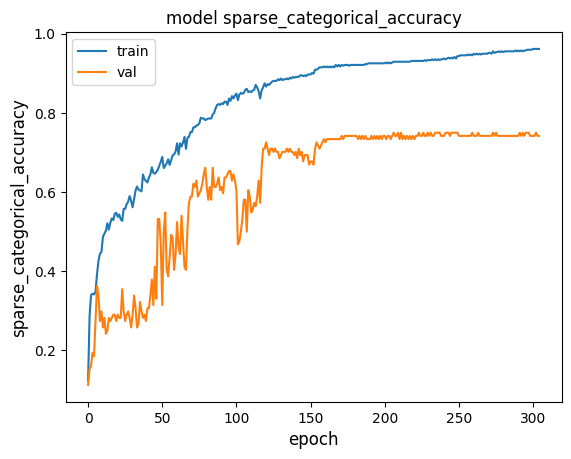

In [18]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Classification Report:
                precision    recall  f1-score   support

          ball       1.00      0.75      0.86         4
       bigball       0.57      0.80      0.67         5
           box       0.80      0.80      0.80         5
        button       0.75      0.50      0.60         6
          case       0.67      0.80      0.73         5
          cube       0.71      1.00      0.83         5
      cylinder       1.00      0.60      0.75         5
         jenga       0.57      0.80      0.67         5
       labello       1.00      0.80      0.89         5
         lemon       0.80      0.80      0.80         5
    metalbrick       1.00      0.40      0.57         5
parallelepiped       0.80      1.00      0.89         4
   smallbutton       0.71      0.83      0.77         6
     smallcube       0.67      0.40      0.50         5
       syringe       0.60      0.75      0.67         4
        tomato       0.80      1.00      

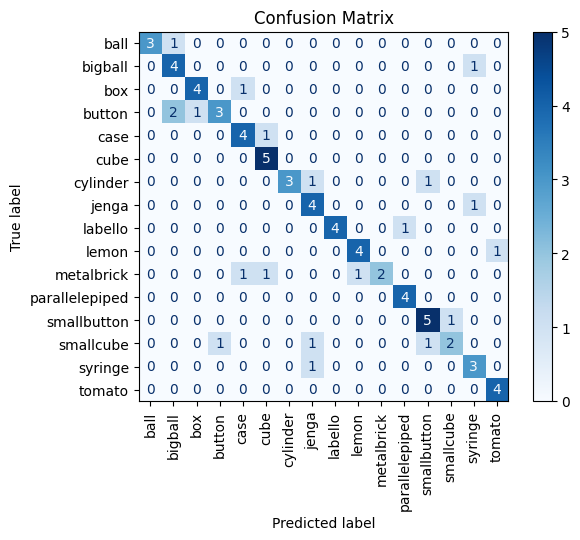

In [19]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str))

labels = np.unique(y_test_str)
cm = confusion_matrix(y_test_str, y_pred_str, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix");

In [20]:
# TODO:
# early stopping su accuracy
# setta meglio parametri non tunable e metti su grid search (usa keras tuner, to tune: kernel_size, filters, the usage of BatchNorm)
# c'è tantissima varianza... (come gestire ripetizioni inizializzazioni?)
# lstm, rocket, altre baselines